In [ ]:
import numpy as np
from utils import timer, load_config, get_current_dt, load_npz, f1_score
import os
import log
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import itertools
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import gradient_descent_v2
from keras.layers import BatchNormalization, Dropout

In [ ]:
logger = log.get_logger(__name__)

# Preprocess + Train

In [ ]:
@timer
def _shuffle_data(trainX, trainY):
    # shuffle dataset
    shuffle_idx = np.random.permutation(len(trainX))
    trainX, trainY = trainX[shuffle_idx], trainY[shuffle_idx]
    return trainX, trainY

@timer
def split_dataset(trainX, trainY):
    """
    Split the training dataset into training and validation datasets.
    """
    trainX, trainY = _shuffle_data(trainX, trainY)
    # split into 40000 and 10000
    trainX, valX = trainX[:40000], trainX[40000:]
    trainY, valY = trainY[:40000], trainY[40000:]
    return trainX, trainY, valX, valY

@timer
def convert_image_data(trainX, testX, valX, float_type='float32', norm_val=255.0):
    """
    Converts pixel values from integers to floats and normalizes to range 0-1.
    """
    # convert from integers to floats and normalize to range 0-1
    trainX = trainX.astype(float_type) / norm_val
    testX = testX.astype(float_type) / norm_val
    valX = valX.astype(float_type) / norm_val
    return trainX, testX, valX

@timer
def encode_labels(trainY, testY, valY):
    """
    One-hot encodes the labels.
    """
    trainY = np_utils.to_categorical(trainY) # e.g. 2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    testY = np_utils.to_categorical(testY)
    valY = np_utils.to_categorical(valY)
    return trainY, testY, valY

@timer
def define_model(num_conv_layers=2, num_filters=32, filter_size=3, 
                 num_dense_layers=1, dense_units=128, 
                 learning_rate=0.001, momentum=0.9, activation='relu',
                 padding='same', use_batch_norm=False, use_dropout=False,
                 dropout_rate=0.2, use_early_stopping=True, patience=2):
    """
    Defines a CNN model with the specified number of convolutional and dense layers, number of filters, filter size,
    learning rate, and momentum for the optimizer. Options for batch normalization, dropout, and early stopping are
    included.
    """
    model = Sequential()
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv2D(num_filters, (filter_size, filter_size), activation=activation, 
                             kernel_initializer='he_uniform', padding=padding, input_shape=(32, 32, 3)))
        else:
            model.add(Conv2D(num_filters, (filter_size, filter_size), activation=activation, 
                             kernel_initializer='he_uniform', padding=padding))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
    # Flatten the output of the convolutional layers
    model.add(Flatten())
    # Add dense layers
    for i in range(num_dense_layers):
        model.add(Dense(dense_units, activation=activation, kernel_initializer='he_uniform'))
        if use_batch_norm:
            model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(dropout_rate))
    # Add output layer
    model.add(Dense(10, activation='softmax'))
    # Compile the model with the specified optimizer, learning rate, and momentum
    opt = gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])
    if use_early_stopping:
        es = EarlyStopping(monitor='val_loss', patience=patience)
        logger.info(f"Using EarlyStopping with patience={patience}.")
        logger.info(f"Model defined: {model.summary()}")
        return model, es
    else:
        logger.info(f"Model defined: {model.summary()}")
        return model

@timer
def save_model(model_path, model, model_name, combination_num, datetime):
    """
    Saves the trained model to disk.
    """
    # Create directory for saving models if it does not exist
    if not os.path.exists(model_path):
        os.makedirs(model_path)
    # Save model architecture and weights
    model.save(f"{model_path}{model_name}_{combination_num}_{datetime}.h5")
    logger(f"Model saved: {model_path}{model_name}_{combination_num}_{datetime}.h5")

@timer
def save_history(history_path, history, model_name, combination_num, datetime):
    """
    Saves the training history to disk.
    """
    # Create directory for saving history if it does not exist
    if not os.path.exists(history_path):
        os.makedirs(history_path)
    
    # Save training history to csv
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f"{history_path}{model_name}_{combination_num}_{datetime}_history.csv", index=False)
    logger.info(f"Training history saved: {history_path}{model_name}_{combination_num}_{datetime}_history.csv")

@timer
def train_model(model, trainX, trainY, valX, valY, batch_size, epochs,
                model_path, model_name, combination_num, datetime):
    """
    Trains the CNN model on the training set and validates on the validation set.
    """
    # define the callback to save the weights
    checkpoint = ModelCheckpoint(f'{model_path}{model_name}_{combination_num}_{datetime}.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 save_weights_only=True, 
                                 verbose=1)

    history = model.fit(trainX, trainY,
                        validation_data=(valX, valY),
                        callbacks=[checkpoint], 
                        batch_size=batch_size, 
                        epochs=epochs,
                        verbose=1)    
    return history

@timer
def plot_performance(history, dataset):
    """
    Plots the loss and accuracy curves and saves the figure to file.
    """
    # create figure with two subplots
    fig = make_subplots(rows=2, cols=1, subplot_titles=('Cross Entropy Loss', 'Classification Accuracy'))
    # plot loss
    fig.add_trace(px.line(history.history, x=history.epoch, y=['loss', 'val_loss'], labels={'value': 'loss', 'variable': ''}).data[0], row=1, col=1)
    # plot accuracy
    fig.add_trace(px.line(history.history, x=history.epoch, y=['accuracy', 'val_accuracy'], labels={'value': 'accuracy', 'variable': ''}).data[0], row=2, col=1)
    # update layout
    fig.update_layout(title=f'{dataset.capitalize()} CIFAR-10 Classification', width=800, height=600)
    return fig

@timer
def save_plot(plot_filepath, fig, dataset, datetime):
    """
    Saves the plot to file.
    """
    # generate file name
    prefix = f"cifar10-classification-{dataset}-{datetime}.png"
    filepath = os.path.join(plot_filepath, prefix)
    # save figure to file
    fig.write_image(filepath)
    logger.info(f"Plot saved: {prefix}")
    
@timer
def train_models(conf, trainX, trainY, valX, valY):
    """
    Trains multiple models with different hyperparameters.
    """
    # generate all possible combinations of hyperparameters
    param_values = list(itertools.product(*conf.a1_q1_hyperparams.values()))
    param_names = list(conf.a1_q1_hyperparams.keys())

    for i, params in enumerate(param_values):
        logger.info(f"Training model {i} with Params: {params}")
        datetime = get_current_dt()
        # create dictionary of hyperparameters for this model
        param_dict = dict(zip(param_names, params))
        # define model with current set of hyperparameters
        model = define_model(**param_dict)
        # train model with current set of hyperparameters
        history = train_model(model, trainX, trainY, valX, valY, 
                              conf.a1_q1_params.batch_size, 
                              conf.a1_q1_params.epochs,
                              conf.paths.a1_model, "cifar10", i, datetime)
        # save trained model and training history
        # save_model(conf.paths.a1_model, "cifar10", i, datetime)
        save_history(conf.paths.a1_history, history, "cifar10", i, datetime)
        fig = plot_performance(history, dataset="validation")
        save_plot(conf.paths.a1_reporting_plots, fig, "validation", datetime)

@timer
def main():
    # load config
    conf = load_config()
    # load data
    data = load_npz(f"{conf.paths.a1_raw_data}cifar10.npz")
    # split training data into training and validation sets
    trainX, trainY, valX, valY = split_dataset(data['trainX'], data['trainY'])
    # convert image data to float32 and normalize
    trainX, testX, valX = convert_image_data(trainX, data['testX'], valX)
    # one-hot encode labels
    trainY, testY, valY = encode_labels(trainY, data['testY'], valY)
    # train models
    train_models(conf, trainX, trainY, valX, valY)

In [ ]:
# main()

# Predict

In [ ]:
import numpy as np
from utils import timer, load_config, get_current_dt, load_npz, f1_score
import os
import log
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.optimizers import gradient_descent_v2

In [ ]:
logger = log.get_logger(__name__)

In [ ]:
@timer
def load_best_model(model_path, learning_rate, momentum):
    """
    Loads a trained model from disk.
    """
    model = load_model(model_path, custom_objects={'f1_score': f1_score})
    opt = gradient_descent_v2.SGD(learning_rate, momentum)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', f1_score])
    return model

@timer
def evaluate_model(model, testX, testY):
    """
    Evaluates the trained model on the test set.
    """
    # evaluate model on test set
    loss, acc, f1 = model.evaluate(testX, testY, verbose=1)
    # print results
    logger.info(f"Test Loss: {loss:.3f}")
    logger.info(f"Test Accuracy: {acc:.3f}")
    logger.info(f"Test F1 Score: {f1:.3f}")
    return loss, acc, f1

@timer
def predict(model, testX, testY):
    """
    Predicts the class labels for the test set.
    """
    # predict class labels for test set
    yhat = model.predict(testX)
    # convert predictions to class labels
    yhat = np.argmax(yhat, axis=1)
    # convert one-hot encoded labels to class labels
    testY = np.argmax(testY, axis=1)
    return yhat, testY

@timer
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap='Blues', 
                          loss=None, accuracy=None, f1=None):
    """
    Plots the confusion matrix.
    """
    # normalize confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        logger.info("Normalized confusion matrix")
    else:
        logger.info('Confusion matrix, without normalization')
    # print confusion matrix
    logger.info(cm)
    
    # create figure
    fig = px.imshow(cm, labels=dict(x="Predicted label", y="True label"), 
                    x=classes, y=classes, color_continuous_scale=cmap,
                    title=title)
    
    # add text for loss, accuracy, and f1 score
    if loss is not None:
        fig.add_annotation(text=f"Loss: {loss:.4f}", xref="paper", yref="paper",
                            x=0.5, y=1.1, showarrow=False)
    if accuracy is not None:
        fig.add_annotation(text=f"Accuracy: {accuracy:.4f}", xref="paper", yref="paper",
                            x=0.5, y=1.05, showarrow=False)
    if f1 is not None:
        fig.add_annotation(text=f"F1 Score: {f1:.4f}", xref="paper", yref="paper",
                            x=0.5, y=1.0, showarrow=False)
    
    return fig


@timer
def save_confusion_matrix(conf, cm, dataset, loss, accuracy, f1):
    """
    Saves the confusion matrix to file.
    """
    datetime = get_current_dt()
    # generate file name
    prefix = f"cifar10-classification-{dataset}-confusion-matrix-{datetime}.png"
    filepath = os.path.join(conf.paths.a1_reporting_plots, prefix)
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # save figure to file
    fig = plot_confusion_matrix(cm, classes, normalize=False, loss=loss, accuracy=accuracy, f1=f1)
    fig.write_image(filepath)
    logger.info(f"Confusion matrix saved: {filepath}")

In [ ]:
# load config
conf = load_config()
# load data
data = load_npz(f"{conf.paths.a1_input_data}cifar10.npz")
# load model
model = load_best_model(conf.paths.a1_q1_model, conf.a1_q1_hyperparams.learning_rate[0], conf.a1_q1_hyperparams.momentum[0])
# evaluate model on test set
loss, acc, f1 = evaluate_model(model, data['testX'], data['testY'])
predY, testY = predict(model, data['testX'], data['testY'])
cm = confusion_matrix(testY, predY)
save_confusion_matrix(conf, cm, dataset='test', loss=loss, accuracy=acc, f1=f1)

In [ ]:
conf = load_config()
model = load_model(conf.paths.a1_q1_model, custom_objects={'f1_score': f1_score})
data = load_npz(f"{conf.paths.a1_input_data}cifar10.npz")
# evaluate model on test set
loss, acc, f1 = evaluate_model(model, data['testX'], data['testY'])
predY, testY = predict(model, data['testX'], data['testY'])
cm = confusion_matrix(testY, predY)
save_confusion_matrix(conf, cm, dataset='test', loss=loss, accuracy=acc, f1=f1)

# Input masking

In [ ]:
from utils import timer, load_config
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import tensorflow.keras.backend as K
import pickle

In [ ]:
@timer
def load_pretrained_model(filepath, local=True):
    if local:
        return load_model(filepath)
    else:
        return VGG16(weights='imagenet')

@timer
def _preprocess_img(img):
    # convert to array
    img = image.img_to_array(img)
    # reshape to 1 sample
    img = np.expand_dims(img, axis=0)
    # preprocess image
    img = preprocess_input(img)
    return img

@timer
def load_sample_img(filepath):
    """
    Loads a sample image from the input data folder.
    """
    # load image
    img = image.load_img(f"{filepath}", target_size=(224, 224))
    return _preprocess_img(img)

@timer
def get_image_class(img_arr, model):
    # Get the predicted class and the corresponding output tensor
    preds = model.predict(img_arr)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    return class_idx, class_output 

@timer
def get_loss(class_output, model):
    # Define the loss function as the mean of the output tensor
    loss = tf.reduce_mean(class_output)
    # Compute the gradient of the loss function with respect to the input image
    grads = tf.GradientTape(loss, model.input)
    return loss, grads

# @timer
# def get_grad_fn(model, class_output):
#     # Define the gradient function for the guided saliency map
#     grads = tf.keras.backend.gradients(class_output, model.input)[0]
#     gradient_fn = tf.keras.backend.function([model.input], [grads])
#     return gradient_fn

# @timer
# def generate_guided_saliency_map(gradient_fn):
#     # Generate the guided saliency map
#     guided_grads = gradient_fn([x])[0]
#     guided_grads /= (tf.sqrt(tf.reduce_mean(tf.square(guided_grads))) + 1e-5)
#     guided_grads *= 0.5
#     return guided_grads

# @timer
# def rescale_map_img(guided_grads, img):
#     # Rescale the guided saliency map and image
#     guided_grads = guided_grads[0]
#     guided_grads = (guided_grads - np.min(guided_grads)) / (np.max(guided_grads) - np.min(guided_grads))
#     img_array = np.array(img) / 255.
#     return guided_grads, img_array

@timer
def generate_saliency_map(x, model, class_idx, patch_size=50, stride=10):
    # Iterate over patches of the input image
    saliency_map = np.zeros((224, 224))
    for i in range(0, 224-patch_size, stride):
        for j in range(0, 224-patch_size, stride):
            # Apply occlusion to the patch by setting it to zero
            occluded_x = x.copy()
            occluded_x[:, i:i+patch_size, j:j+patch_size, :] = 0
            # Compute the output probability of the correct class for the occluded patch
            output = model.predict(occluded_x)
            saliency_map[i:i+patch_size, j:j+patch_size] = output[0, class_idx]
    # Normalize the saliency map to [0, 1]
    saliency_map -= np.min(saliency_map)
    saliency_map /= np.max(saliency_map)
    return saliency_map

In [ ]:
# def plot_saliency_map(guided_grads, class_idx, img):
#     # Create the saliency map and add the predicted class label to the image
#     fig = px.imshow(guided_grads, binary_string=True, opacity=0.8, color_continuous_scale='viridis')
#     fig.add_layout_image(dict(
#         source=img,
#         xref="x",
#         yref="y",
#         x=0,
#         y=0,
#         sizex=img.shape[1],
#         sizey=img.shape[0],
#         sizing="stretch",
#         opacity=1,
#         layer="below")
#     )
#     fig.update_xaxes(visible=False)
#     fig.update_yaxes(visible=False)
#     fig.update_layout(title_text=f"Predicted Class: {class_idx}", title_x=0.5, title_y=0.95)
#     fig.show()

In [ ]:
def main():
    conf = load_config()
    img_paths = ['example_pomeranian.jpeg', 'example_carwheel.jpg', 'example_afghanhound.jpg']
    model = load_pretrained_model(conf, local=False)
    # Load the labels for the ImageNet dataset
    imagenet_labels = pickle.load(open(f'{conf.paths.a1_imagenet_labels}', 'rb'))
    for img_path in img_paths:
        img = load_sample_img(f"{conf.paths.a1_raw_data}{img_path}")
        class_idx, _ = get_image_class(img, model)
        # loss, grads = get_loss(class_output, model)
        saliency_map = generate_saliency_map(img, model, class_idx)
        fig, ax = plt.subplots()
        im = ax.imshow(saliency_map, cmap='jet')
        fig.colorbar(im, ax=ax)
        ax.set_title('Saliency Map\nPredicted Class: ' + imagenet_labels[class_idx])
        plt.axis('off')
        plt.savefig('saliency_map_'+img_path, bbox_inches='tight')
        plt.close()

In [ ]:
# def main():
#     conf = load_config()
#     img_paths = ['example_pomeranian.jpeg', 'example_carwheel.jpg', 'example_afghanhound.jpg']
#     model = load_pretrained_model(conf, local=False)
#     for img_path in img_paths:
#         img = load_sample_img(f"{conf.paths.a1_raw_data}{img_path}")
#         class_idx, class_output = get_image_class(img, model)
#         # loss, grads = get_loss(class_output, model)
#         gradient_fn = get_grad_fn(model, class_output)
#         guided_grads = generate_guided_saliency_map(gradient_fn)
#         guided_grads, img_array = rescale_map_img(guided_grads, img)
#         plot_saliency_map(guided_grads, img_array, class_idx, img)
        # saliency_map = generate_saliency_map(img, model, class_idx)
        # plt.imshow(saliency_map, cmap='jet')
        # plt.axis('off')
        # plt.savefig('saliency_map_'+img_path, bbox_inches='tight')
        # plt.close()

In [ ]:
main()

# Adversarial Attack

In [6]:
from utils import load_config, timer #load_pretrained_model, load_sample_img, get_image_class, 
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input

In [7]:
@timer
def load_pretrained_model(filepath, local=True):
    if local:
        return load_model(filepath)
    else:
        return VGG16(weights='imagenet')

In [8]:
# def generate_adversarial_example(model, image, epsilon):
#     """
#     Generate adversarial example for a given image using the fast gradient sign method.

#     :param model: Keras model to generate adversarial example for.
#     :param image: Input image to generate adversarial example for.
#     :param epsilon: Magnitude of the perturbation.
#     :return: Adversarial example.
#     """
#     # Define the input tensor and target tensor
#     input_tensor = model.input
#     target_tensor = K.placeholder(shape=model.output_shape[1:])

#     # Calculate the loss and gradient
#     loss = K.categorical_crossentropy(target_tensor, model.output)
#     gradient = K.gradients(loss, input_tensor)[0]

#     # Define a function to calculate the gradient of the loss with respect to the input
#     get_gradient = K.function(inputs=[input_tensor, target_tensor], outputs=[gradient])

#     # Get the gradient of the loss with respect to the input
#     gradient_value = get_gradient([image, np.zeros((1, model.output_shape[1]))])[0]

#     # Calculate the sign of the gradient
#     sign = np.sign(gradient_value)

#     # Generate the adversarial example
#     adversarial_example = image + epsilon * sign
#     adversarial_example = np.clip(adversarial_example, 0, 1)

#     return adversarial_example



# import keras.backend as K

# def generate_adversarial_example(model, input_image, epsilon):
#     # Define the loss function
#     output = model.output
#     target_class = K.argmax(output, axis=1)
#     loss = K.categorical_crossentropy(output, K.one_hot(target_class, 1000))
    
#     # Compute the gradient of the loss with respect to the input
#     input_tensor = model.input
#     gradients = K.gradients(loss, input_tensor)[0]
    
#     # Normalize the gradients
#     gradients /= K.maximum(K.mean(K.abs(gradients)), K.epsilon())
    
#     # Define the function to compute the adversarial example
#     iterate = K.function([input_tensor], [loss, gradients])
    
#     # Generate the adversarial example
#     perturbation = np.sign(iterate([input_image])[1])
#     adversarial_example = input_image + epsilon * perturbation
#     adversarial_example = np.clip(adversarial_example, 0, 255).astype('uint8')
    
#     return adversarial_example

In [9]:


def generate_adversarial_example(model, input_image, epsilon):
    # Define the loss function
    target_class = tf.argmax(model(input_image), axis=1)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss = lambda input_image: loss_fn(model(input_image), tf.one_hot(target_class, 1000))
    
    # Compute the gradient of the loss with respect to the input
    input_tensor = tf.Variable(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        loss_value = loss(input_tensor)
    gradient = tape.gradient(loss_value, input_tensor)
    
    # Normalize the gradient
    gradient /= tf.maximum(tf.reduce_mean(tf.abs(gradient)), tf.keras.backend.epsilon())
    
    # Generate the adversarial example
    perturbation = tf.sign(gradient)
    adversarial_example = input_image + epsilon * perturbation
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 255)
    adversarial_example = tf.cast(adversarial_example, tf.uint8)
    
    return adversarial_example.numpy()


In [10]:
conf = load_config()

23-Apr-23 21:23:17 - INFO - Starting 'load_config'.
23-Apr-23 21:23:17 - INFO - Finished 'load_config' in 0.0225 secs.


In [16]:
# Load a pre-trained Keras model
model = load_pretrained_model(conf, local=False)

# Load an image
img_path = '../data/01_raw/example_pomeranian.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)

# Generate an adversarial example
epsilon = 0.05
adversarial_example = generate_adversarial_example(model, x, epsilon)

# Make a prediction on the original image and the adversarial example
original_prediction = model.predict(x)
adversarial_prediction = model.predict(adversarial_example)

# Print the predictions
print('Original prediction:', keras.applications.vgg16.decode_predictions(original_prediction))
print('Adversarial prediction:', keras.applications.vgg16.decode_predictions(adversarial_prediction))


23-Apr-23 21:31:35 - INFO - Starting 'load_pretrained_model'.
23-Apr-23 21:31:37 - INFO - Finished 'load_pretrained_model' in 1.8026 secs.


AttributeError: 'numpy.ndarray' object has no attribute 'load_img'

2023-04-23 21:34:38.714858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 21:34:39.280202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


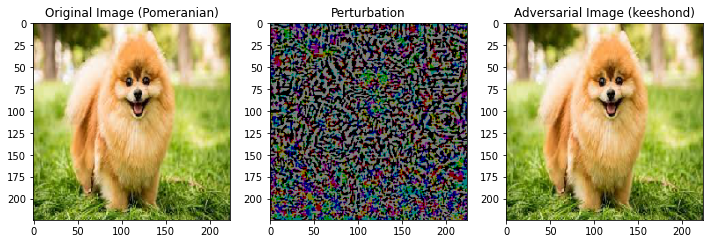

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the VGG16 model pre-trained on ImageNet
model = tf.keras.applications.VGG16()

# Load an example image
image_path = "../data/01_raw/example_pomeranian.jpeg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

# Get the predicted label for the original image
preds = model.predict(image)
original_label = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0][1]

# Generate an adversarial example
epsilon = 0.05
adversarial_image = generate_adversarial_example(model, image, epsilon)

# Get the predicted label for the adversarial image
preds_adv = model.predict(adversarial_image)
adversarial_label = tf.keras.applications.vgg16.decode_predictions(preds_adv, top=1)[0][0][1]

image = np.squeeze(image)
adversarial_image = np.squeeze(adversarial_image)

# Plot the original image, the noise, and the adversarial image
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].imshow(image / 255.)
axes[0].set_title(f"Original Image ({original_label})")
axes[1].imshow((adversarial_image - image) / (2 * epsilon) + 0.5)
axes[1].set_title("Perturbation")
axes[2].imshow(adversarial_image / 255)
axes[2].set_title(f"Adversarial Image ({adversarial_label})")
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load pre-trained model
model = tf.keras.applications.VGG16(weights='imagenet')

# Load an example image
img_path = "../data/01_raw/example_pomeranian.jpeg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, (224, 224))
# x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.vgg16.preprocess_input(img)
x = np.expand_dims(x, axis=0)
# x = x[None, ...]

def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Get the predicted class for the image
preds = model.predict(x)
predicted_class = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0]
class_idx = np.argmax(preds[0])

loss = tf.keras.losses.categorical_crossentropy(tf.one_hot(class_idx, 1000), np.squeeze(preds))
grads = tf.GradientTape(loss, model.input)#[0]

# # Compute the sign of the gradients
# sign_grads = tf.sign(grads)

In [ ]:
def create_adversarial_pattern(input_image, class_idx, preds):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.categorical_crossentropy(tf.one_hot(class_idx, 1000), np.squeeze(preds))

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [ ]:
signed_grad = create_adversarial_pattern(x, class_idx, preds)

In [ ]:
# Load pre-trained model
model = tf.keras.applications.VGG16(weights='imagenet')

# Load an example image
img_path = "../data/01_raw/example_pomeranian.jpeg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = np.expand_dims(x, axis=0)

# Get the predicted class for the image
preds = model.predict(x)
predicted_class = tf.keras.applications.vgg16.decode_predictions(preds, top=1)[0][0]
class_idx = np.argmax(preds[0])

# Compute the loss
loss_fn = tf.keras.losses.CategoricalCrossentropy()
loss = lambda x: loss_fn(tf.reshape(tf.one_hot(123, 1000), [1, 1000]), x)
grads_fn = tf.GradientTape(persistent=True)
with grads_fn:
    loss_value = loss(model(x, training=False))

# Compute the sign of the gradients
grads = grads_fn.gradient(loss_value, model.input)
sign_grads = tf.sign(grads)
sign_grads = tf.reshape(sign_grads, x.shape)

In [ ]:




# Compute the loss with respect to the predicted class
# predicted_class = tf.argmax(preds, axis=-1, output_type=tf.int32)
loss = tf.keras.losses.categorical_crossentropy(tf.one_hot(predicted_class[0], 1000), preds)
grads = tf.gradients(loss, model.input)[0]

# Compute the sign of the gradients
sign_grads = tf.sign(grads)

# Generate adversarial example by adding the sign of the gradients to the original image
adv_x = x + 0.01 * sign_grads
adv_x = tf.clip_by_value(adv_x, -1, 1)

# Get the predicted class for the adversarial example
adv_preds = model.predict(adv_x)
adv_predicted_class = tf.keras.applications.vgg16.decode_predictions(adv_preds, top=1)[0][0]

# Plot the original image and the adversarial example
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[0].set_title(f'Original\n{predicted_class[1]}')
axs[0].axis('off')
axs[1].imshow(tf.keras.preprocessing.image.array_to_img(adv_x[0]))
axs[1].set_title(f'Adversarial\n{adv_predicted_class[1]}')
axs[1].axis('off')
plt.show()
